# Texata Round 1

## Introduction

This is a notebook I created for practicing for the final round of Texata 2015. I decided that the best way to try all the new visualization and data processing libraries out there would be to re-do the Round 1 exercises in the best way I could imagine. The result is this, which I think showcases some interesing Python libraries. Enjoy!

In [32]:
# Load all dependencies
%matplotlib inline
import pandas
from scipy.stats.stats import pearsonr
import numpy as np
import time
from scipy import stats
import math
import matplotlib.pylab as plt
import folium
import seaborn as sns
# This is just to make images bigger
sns.set_context("poster")

## Load data

The data for this round was provided as  CSV file with the following columns:
* Restaurant Name
* Zip Code
* Inspection Date
* Score
* Address
* Facility ID
* Process Description

We can read it easily using Pandas:

In [33]:
data = pandas.read_csv("Restaurant_Inspection_Scores.csv")

Let's take a look at the first 10 lines of data:

In [34]:
data.head()

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description
0,15th Street Cafe,78701,05/22/2013,91,"303 W 15TH ST\nAUSTIN, TX 78701\n(30.277693, -...",2801033,Routine Inspection
1,15th Street Cafe,78701,05/13/2015,97,"303 W 15TH ST\nAUSTIN, TX 78701\n(30.277693, -...",2801033,Routine Inspection
2,15th Street Cafe,78701,06/18/2014,97,"303 W 15TH ST\nAUSTIN, TX 78701\n(30.277693, -...",2801033,Routine Inspection
3,15th Street Cafe,78701,09/13/2012,93,"303 W 15TH ST\nAUSTIN, TX 78701\n(30.277693, -...",2801033,Routine Inspection
4,15th Street Cafe,78701,12/05/2013,97,"303 W 15TH ST\nAUSTIN, TX 78701\n(30.277693, -...",2801033,Routine Inspection


Now we can take a look at a summary of the numeric variables in the data by using the *describe* function:

In [35]:
data.describe()

,Zip Code,Score,Facility ID
count,21958.000000,21958.000000,21958.00000
mean,78728.460834,91.541944,6991787.20143
std,29.260032,7.705494,3844583.15620
min,78610.000000,42.000000,2800004.00000
25%,78704.000000,87.000000,2801830.00000
50%,78738.000000,93.000000,10014353.00000
75%,78750.000000,97.000000,10530244.00000
max,78759.000000,100.000000,11292287.00000


ZIP Code and facility ID metrics are not useful, but those for the score are. The average sanitary score in Austin is 91.51: these guys take health quite seriously!

We can also plot a histogram of these variables as:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4494e1b90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa448e8ad90>]], dtype=object)

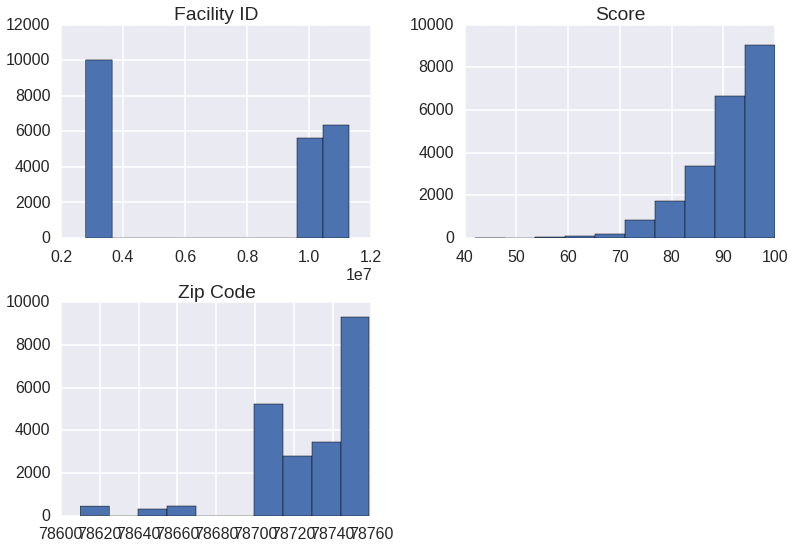

In [36]:
data.hist()

So most restaurants in the city are of good sanitary quality.

OK, enough playing around: let's address the questions in the exercise.

## Question 58
### Are there significant differences in sanitation scores between different parts of the city?

An easy way of splitting the data in different city parts is by ZIP code. Let's take the set of all ZIP codes in the date, and the list of scores per ZIP:

In [37]:
zips = sorted(list(set(data['Zip Code'])))
zipscores = {zipnumber : data[data["Zip Code"] == zipnumber]["Score"] for zipnumber in zips}

Now let's create a bar plot of the average scores per ZIP using *seaborn*:

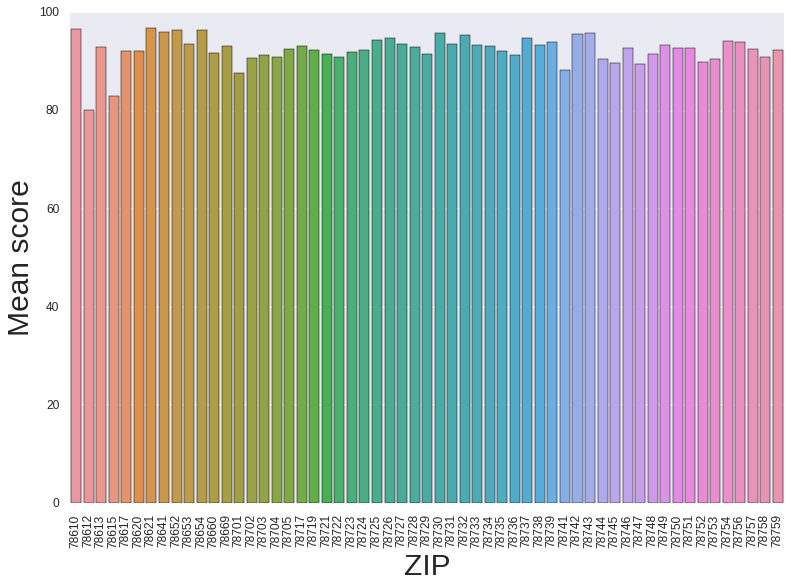

In [38]:
means = [np.mean(zipscores[zip]) for zip in  zips]
sns.barplot(x=zips, y=means)
plt.xlabel("ZIP", fontsize=30)
plt.ylabel("Mean score", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation='vertical')
plt.show()

There are noticeable differences in average scores. But, are these relevant under some significancy test? We need to test that as well. To do so we will first compute all the cross differences in mean scores :

In [39]:
diffs = [[np.mean(zipscores[zip1]) - np.mean(zipscores[zip2]) for zip1 in zips] for zip2 in zips]

Now let's run a t-test for significancy at the 0.01 level (very significant) for each list of scores between every possible pair of ZIPs, and note down those differences that are not really significant:

In [40]:
significancy = 0.01
mask = [[stats.ttest_ind(zipscores[zip1],zipscores[zip2])[1] > significancy for zip1 in zips] for zip2 in zips]

Now we will plot a heatmap of the average differences in scores between ZIPs, but only for those differences that are significant in the t-test above. To do so we will use a *seaborn* heatmap plot with the relevancy mask computed above:

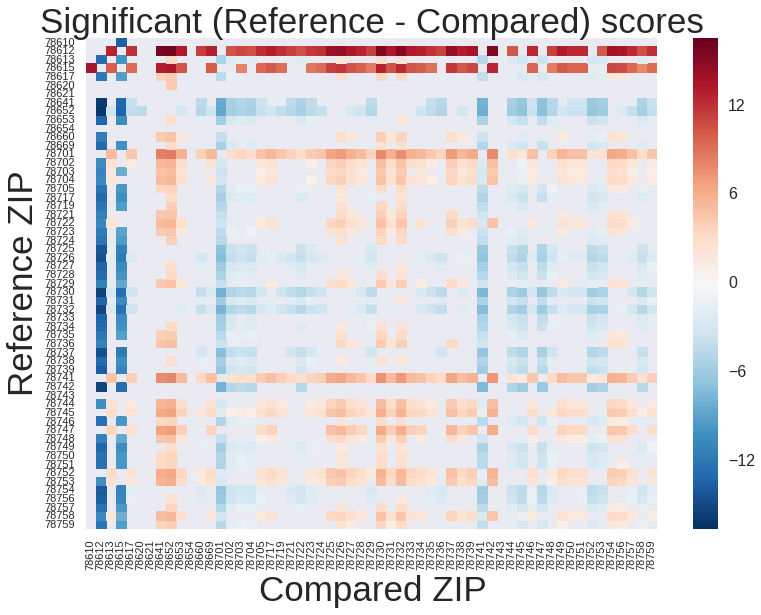

In [41]:
sns.heatmap(np.array(diffs), mask = np.array(mask), xticklabels = zips, yticklabels = zips)
plt.ylabel("Reference ZIP", fontsize=35)
plt.xlabel("Compared ZIP", fontsize=35)
plt.title("Significant (Reference - Compared) scores", fontsize=35)
plt.tick_params(axis='both', which='major', labelsize=11)

Well that is interesting! Some areas such as ZIP 78612 have significantly better sanitary levels than the rest of the places in Austin, so you might want to check that for your dinner!

All in all we can safely say that there are significant differences in scores between ZIPs.

## Question 59 
### Are there significant differences between general scores and scores of the last inspection, when it was a followup after an inspection of score 50-59?

This question again reduces to a perform a significancy test, this time between the series of general scores and the series of scores after an inspection of score 50-59. Since we will need to work with the dates in the data but these are in string format, let's first add a new column to the dataframe with the processed date:

In [42]:
dates = [time.strptime(row["Inspection Date"], "%m/%d/%Y") for index, row in data.iterrows()]
data['Processed Date'] = pandas.Series(dates)

Now that we have the dates we can take the last inspection for each restaurant. We do this by ordering by date dropping all but the last register for each Address:

In [43]:
lastinspections = data.copy().sort_values(by='Processed Date').drop_duplicates(subset="Address", keep="last")

Now we can find the inspections after a bad score by looking at the field "Process Description":

In [44]:
badinspections = lastinspections[lastinspections["Process Description"] == '1st Follow Up to Routine of 50 - 69']

Now we get the series of general scores and those for the bad inspections, and run the t-test for significancy:

In [45]:
generalscores = data['Score']
inspectionscores = badinspections['Score']
print "General scores vs inspected = ", stats.ttest_ind(generalscores, inspectionscores)

General scores vs inspected =  Ttest_indResult(statistic=6.7067973615025309, pvalue=2.0377095892782499e-11)


The p-value is extremely small, so there is a significant difference. We can actually visualize this through a *matplotlib* boxplot:

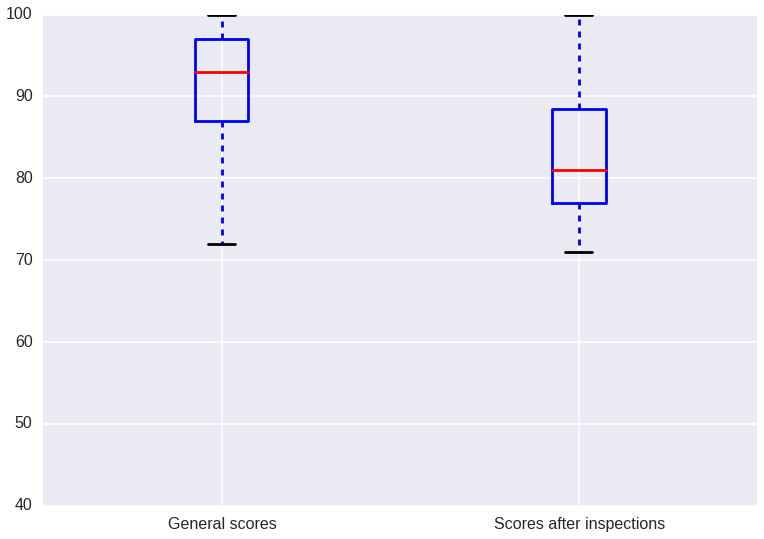

In [63]:
plt.boxplot([generalscores, inspectionscores], labels=['General scores', 'Scores after inspections'])
plt.show()

So I guess some guys just don't learn their lesson?

## Question 60
### Has there been a significant difference in the sanitation trend along time?

Working with time data is always difficult, but since our dataset spans several years of inspections, we can take a simple approach by breaking the data down by years and testing for significancy of scores between years. To do so, let's first create a new column in the dataframe with just the year, to aid the following steps:

In [47]:
years = [date.tm_year for date in data["Processed Date"]]
data["Year"] = pandas.Series(years)

We will now perform a trellis of the dataset, which essentially means generating several versions of the same plot, each with a subset of interest of our data. This can be done with *seaborn*, indicating the variable to use for the subset generation, in this case the year. We will also specify that the plots to generate will be distribution plots of the scores:

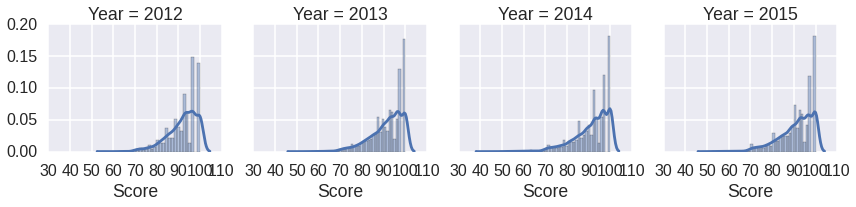

In [48]:
uniqueyears = list(data["Year"].drop_duplicates().sort_values())
g = sns.FacetGrid(data, col="Year", col_order=uniqueyears)
g.map(sns.distplot, "Score")

So, the general shape of the score distribution remains almost the same every year, except for some minor variations. We can take a look at the overall mean values by just generating a barplot:

[92.047053836371347,
 91.587282847023104,
 91.539397010387631,
 91.292590027700825]

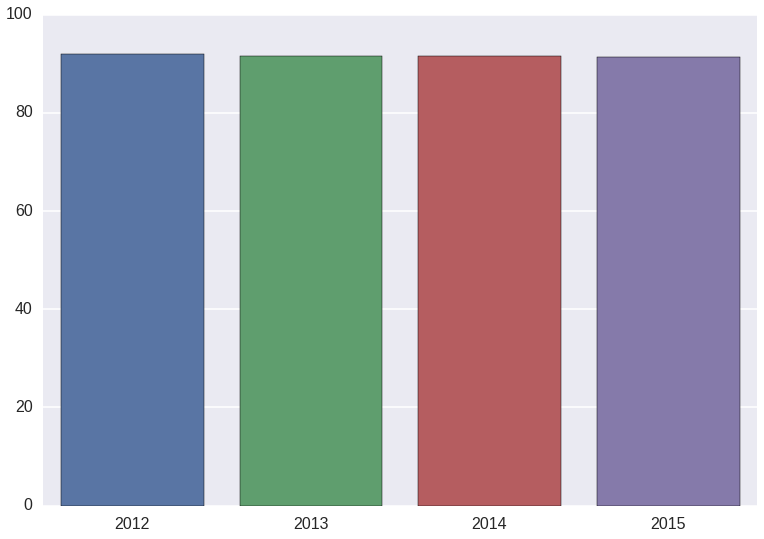

In [49]:
scoreyears = [np.mean(data[data["Year"] == year]["Score"]) for year in uniqueyears]
sns.barplot(x=uniqueyears, y=scoreyears)
scoreyears

There doesn't really seem to be any difference among years, but to make this 100% we will generate a heatmap of the differences masked by a significancy test as we did before for the ZIPs data:

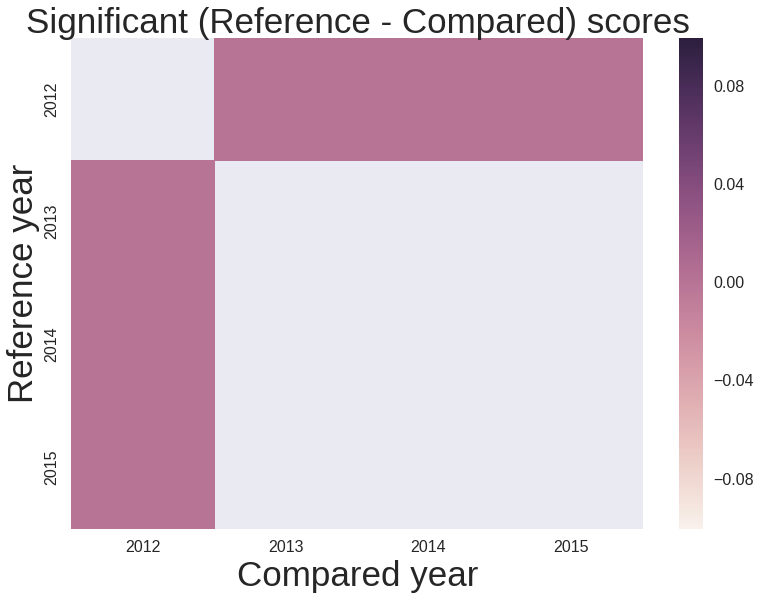

In [64]:
diffs = [[np.mean(data[data["Year"] == year1]["Score"]) - np.mean(data[data["Year"] == year1]["Score"]) 
          for year1 in uniqueyears] for year2 in uniqueyears]
mask = [[stats.ttest_ind(data[data["Year"] == year1]["Score"],data[data["Year"] == year2]["Score"])[1] > significancy 
          for year1 in uniqueyears] for year2 in uniqueyears]
sns.heatmap(np.array(diffs), mask = np.array(mask), xticklabels = uniqueyears, yticklabels = uniqueyears)
plt.ylabel("Reference year", fontsize=35)
plt.xlabel("Compared year", fontsize=35)
plt.title("Significant (Reference - Compared) scores", fontsize=35)

So, the scores in the first year are better than those in the years to follow with sufficient statistical confidence. However the actual difference in score values is very small, and furthermore this decreasing trend does not continue in the following years with sufficient significancy. So my verdict is that there is not really a trend in here.

## Question 61
### If we were to open a new restaurant in the intersection of West Martin Luther King Jr Boulevard and Lavaca Street, what sanitary score should we expect there, based on the scores of the 3 nearest restaurants?

Let us first note down the names of the streets:

In [51]:
street1 = "W MARTIN LUTHER KING JR BLVD".upper()
street2 = "LAVACA ST".upper()

Now, geodata is included in the dataset in the form of latitude and longitude measurements. The problem is, this is written down in string form and as part of the address field, for instance:

In [52]:
data["Address"][0]

'303 W 15TH ST\nAUSTIN, TX 78701\n(30.277693, -97.742469)'

So we will need to parse this string for every row in our dataframe and extract the longitude and latitude values. To make further reference to these fields easier we will add these two values as new columns:

In [53]:
coords = [reg[1]['Address'].split('\n')[2].replace('(','').replace(')','').split(',') for reg in data.iterrows()]
# Transform to floats (if possible)
coords = [[float(x) for x in coord if x != ''] for coord in coords]
# Split in longitudes and latitudes
lats = [entry[0] if len(entry) > 0 else None for entry in coords]
longs = [entry[1] if len(entry) > 0 else None for entry in coords]
# Add back to dataframe
data['Latitude'] = pandas.Series(lats)
data['Longitude'] = pandas.Series(longs)
# See result
data[['Latitude', 'Longitude']].head()

,Latitude,Longitude
0,30.277693,-97.742469
1,30.277693,-97.742469
2,30.277693,-97.742469
3,30.277693,-97.742469
4,30.277693,-97.742469


Looks good! Now let's find the restaurants in those streets, so we can have an idea of where the actual streets are located:

In [54]:
# Get restaurants in those streets
stregs = data[[street1 in addr or street2 in addr for addr in data["Address"]]]
# Get locations of such restaurants
stlocs = stregs[["Longitude", "Latitude"]].drop_duplicates()

A good way to visualize geospatial data is to use the *folium* package, which allows to plot points on top of a OpenStreetMap map. We will plot a map of Austin with the restaurants in the streets of interest highlighted:

In [55]:
# Create a map centered on the approximate coordinates of Austin
austinlat = 30.301534
austinlon = -97.759620
restmap = folium.Map(location=[austinlat, austinlon], zoom_start=13)
# Add markers for the identified restaurants
for index, row in stlocs.iterrows():
    restmap.circle_marker([row["Latitude"], row["Longitude"]], fill_color = 'blue', radius = 10)
# Allow clicking to get coordinates
restmap.lat_lng_popover()
# Draw map
restmap

There they are! We have created the map in a way that we can interactively click on a point and get its lat-lon coordinates. By doing so we can pick the coordinates of the crossing of these streets, namely:

In [56]:
latcross = 30.2813
loncross = -97.7405

To check we have done so properly, let's plot again the map with the location of our new fancy restaurant at a higher zoom level:

In [57]:
# Create a map centered on our new restaurant at Austin
restmap = folium.Map(location=[latcross, loncross], zoom_start=17)
# Add markers for the identified restaurants
for index, row in stlocs.iterrows():
    restmap.circle_marker([row["Latitude"], row["Longitude"]], fill_color = 'blue', radius = 10)
# Add market for proposed location of new restaurant
restmap.circle_marker([latcross, loncross], fill_color = 'red', radius = 15)
# Draw map
restmap

Our new restaurant is located right on the AT&T Executive Education and Conference Center. This is the place where the Texata finals took place! So we have found a self-referential pun in the data. Nice! :)

But we still have a problem to solve. We need to find the 3 nearest restaurants to these points. Computing distances of points expressed in lon-lat coordinates can be tricky for distant points, due to the curvature of the Earth and whatnot. Since we are only working with coordinates within a city we can safely approximate real distance by a simple euclidean distance. Let's compute just that for every unique restaurant position, and save the result as a new column in an auxiliary dataframe:

In [58]:
datadist = data.copy().drop_duplicates(subset=['Longitude','Latitude'])
distances = []
for index, row in datadist.iterrows():
    distance = math.sqrt(math.pow(row['Longitude'] - loncross, 2) + math.pow(row['Latitude'] - latcross, 2))
    distances.append(distance)
datadist['Distance'] = pandas.Series(distances, index=datadist.index)

Now that we have computed the distances we need to find the nearest competitors to our planned new restaurant. This is easy to do with a simple sorting:

In [59]:
# Sort candidates by distances
sortedcands = datadist.sort_values(by='Distance')

# 3 nearest restaurants
nearest = sortedcands[0:3]
nearest

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description,Processed Date,Year,Latitude,Longitude,Distance
18957,TCBY,78701,11/30/2012,94,"303 W MARTIN LUTHER KING JR BLVD\nAUSTIN, TX 7...",2801749,Routine Inspection,"(2012, 11, 30, 0, 0, 0, 4, 335, -1)",2012,30.281464,-97.741028,0.000553
20231,University Ave Church,78705,11/20/2012,93,"1903 UNIVERSITY AVE\nAUSTIN, TX 78705\n(30.281...",2800271,Routine Inspection,"(2012, 11, 20, 0, 0, 0, 1, 325, -1)",2012,30.281268,-97.739790,0.000711
14292,Pizza Hut,78701,07/24/2014,100,"1811 GUADALUPE ST\nAUSTIN, TX 78701\n(30.28102...",2802469,Routine Inspection,"(2014, 7, 24, 0, 0, 0, 3, 205, -1)",2014,30.281020,-97.741811,0.001341


That Pizza Hut certainly takes health issues very seriously! Let's make a new map pinpointing where these restaurants are:

In [60]:
# Create a map centered on our new restaurant at Austin
restmap = folium.Map(location=[latcross, loncross], zoom_start=17)
# Add markers for nearest restaurants in Austin
for index, row in nearest.iterrows():
    restmap.circle_marker([row["Latitude"], row["Longitude"]], fill_color = 'green', radius = 10)
# Add market for proposed location of new restaurant
restmap.circle_marker([latcross, loncross], fill_color = 'red', radius = 15)
# Draw map
restmap

One of those is on the EAST side of Martin Luther King Jr Boulevard. So, had we used only the data of the restaurants in the West Martin Luther King Jr Boulevard and Lavaca Street we would have missed it!

Now let's get the list of all the scores of those three restaurants, and compute an average to estimate the most probable score for our new place!

In [61]:
# Get all available data of the nearest restaurants (look for reviews with address in the nearest set)
nearestdata = data[data["Address"].isin(nearest["Address"])]

# Get the average of those scores
expectedscore = np.mean(nearestdata["Score"])

print("Predicted score for new restaurant = ", expectedscore)

('Predicted score for new restaurant = ', 94.166666666666671)


And that's it! Our hypothetical restaurant will do pretty well in the sanitary inspection. So if I ever run out of business in the data industry maybe I should try opening some *tapas* pub? :)

## Closing

I can truly say that just by preparing, competing, and then revising this first round exercise I have learned a lot! This was the first time I made a Jupyter notebook and used most of the packages you can see here. Had I tried to do all of these with my old C and Java knowledge I would have never made it. Knowing and leveraging the appropriate tools is a great help, both for this competition and for the real world. I'm already using these tools for actual projects at my job!